In [1]:
import sys
import os
from itertools import cycle
from time import time

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from sklearn.linear_model import LassoLars
from sklearn.preprocessing import StandardScaler

sys.path.append(os.pardir)
sys.path.append(os.path.join(os.pardir, os.pardir))
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

from src.dataset.dataloaders import get_dataset
from src.dictionary.basic_dictionary_learning import base_algo1, batched_algo1
from src.dictionary.parallel_dict_learning import algo1 as batched_algo1_parallel


In [2]:
train_loader, val_loader, test_loader = get_dataset("berkeley",  patch_size=(16, 16), patches_per_image=5, batch_size=16)

for p in train_loader:
    print(p.shape)  # [bs, c, h, w]
    break

torch.Size([16, 3, 16, 16])


# Base pipeline

## View data

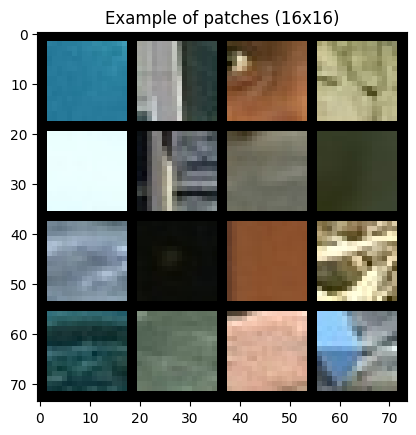

In [3]:
def plot_patches(patches, nrow=4):
    grid = make_grid(patches[:nrow*nrow], nrow=nrow, normalize=True, value_range=(0, 1))
    grid_np = grid.permute(1, 2, 0).cpu().numpy()

    plt.imshow(grid_np)
    plt.title(f"Example of patches ({patches.shape[2]}x{patches.shape[3]})")
    plt.show()

for p in train_loader:
    plot_patches(p, nrow=4)
    break

## Train

In [ ]:
infinite_x_loader = cycle(train_loader)
m = 16*16*3
D = batched_algo1(infinite_x_loader, m=m, k=200, lbd=1.2/np.sqrt(m), tmax=int(1e4))

  0%|          | 0/10000 [00:00<?, ?it/s]

 18%|█▊        | 1848/10000 [01:40<06:53, 19.74it/s]/Users/paul/.pyenv/versions/3.10.14/envs/ml4ts_venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=1.083e-03, previous alpha=1.083e-03, with an active set of 34 regressors.
  warnings.warn(
 21%|██        | 2105/10000 [01:54<06:42, 19.63it/s]/Users/paul/.pyenv/versions/3.10.14/envs/ml4ts_venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=1.569e-03, previous alpha=1.569e-03, with an active set of 27 regressors.
  warnings.warn(
 47%|████▋     | 4678/10000 [04:03<04:17, 20.70it/s]/Users/paul/.pyenv/versions/3.10.14/envs/ml4ts_venv/lib/python3.10/site-packages/sklearn/linear_mode

## Util

In [9]:
scaler = StandardScaler()
def visualize_reconstruction(D, loader):
    for _ in range(3):
        patch_x = next(loader)[0]  # [c, p_h, p_w]
        x = torch.flatten(patch_x)  # [c*p_h*p_w] = [m]
        x_np = x.numpy().reshape(-1, 1)
        x_scaled = scaler.fit_transform(x_np).flatten()

        lasso = LassoLars(alpha=0.001, fit_intercept=False)
        lasso.fit(X=D, y=x_scaled)
        alpha = torch.tensor(lasso.coef_, dtype=torch.float32)

        x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()
        x_reconstructed = scaler.inverse_transform(x_reconstructed_scaled.reshape(-1, 1)).flatten()

        original_x = x_np.reshape(3, 16, 16).transpose(1, 2, 0)  # [H, W, C]
        scaled_x = x_scaled.reshape(3, 16, 16).transpose(1, 2, 0)  # [H, W, C]
        reconstructed_x = x_reconstructed.reshape(3, 16, 16).transpose(1, 2, 0)  # [H, W, C]

        original_rgb = (original_x - np.min(original_x)) / (np.max(original_x) - np.min(original_x))
        scaled_rgb = (scaled_x - np.min(scaled_x)) / (np.max(scaled_x) - np.min(scaled_x))
        reconstructed_rgb = (reconstructed_x - np.min(reconstructed_x)) / (np.max(reconstructed_x) - np.min(reconstructed_x))

        plt.figure(figsize=(16, 8))

        plt.subplot(2, 3, 1)
        plt.imshow(original_rgb)
        plt.title("Original X (RGB)")
        plt.axis("off")

        plt.subplot(2, 3, 2)
        plt.imshow(scaled_rgb)
        plt.title("Scaled X (RGB)")
        plt.axis("off")

        plt.subplot(2, 3, 3)
        plt.imshow(reconstructed_rgb)
        plt.title("Reconstructed X (RGB)")
        plt.axis("off")

        plt.subplot(2, 1, 2)
        plt.bar(np.arange(len(alpha)), alpha.numpy())
        plt.title("Alpha Activations")
        plt.xlabel("Dictionary Index")
        plt.ylabel("Activation Magnitude")
        plt.tight_layout()

        plt.show()



## Reconstruction

### Train Dataset

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_47865/522856424.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()


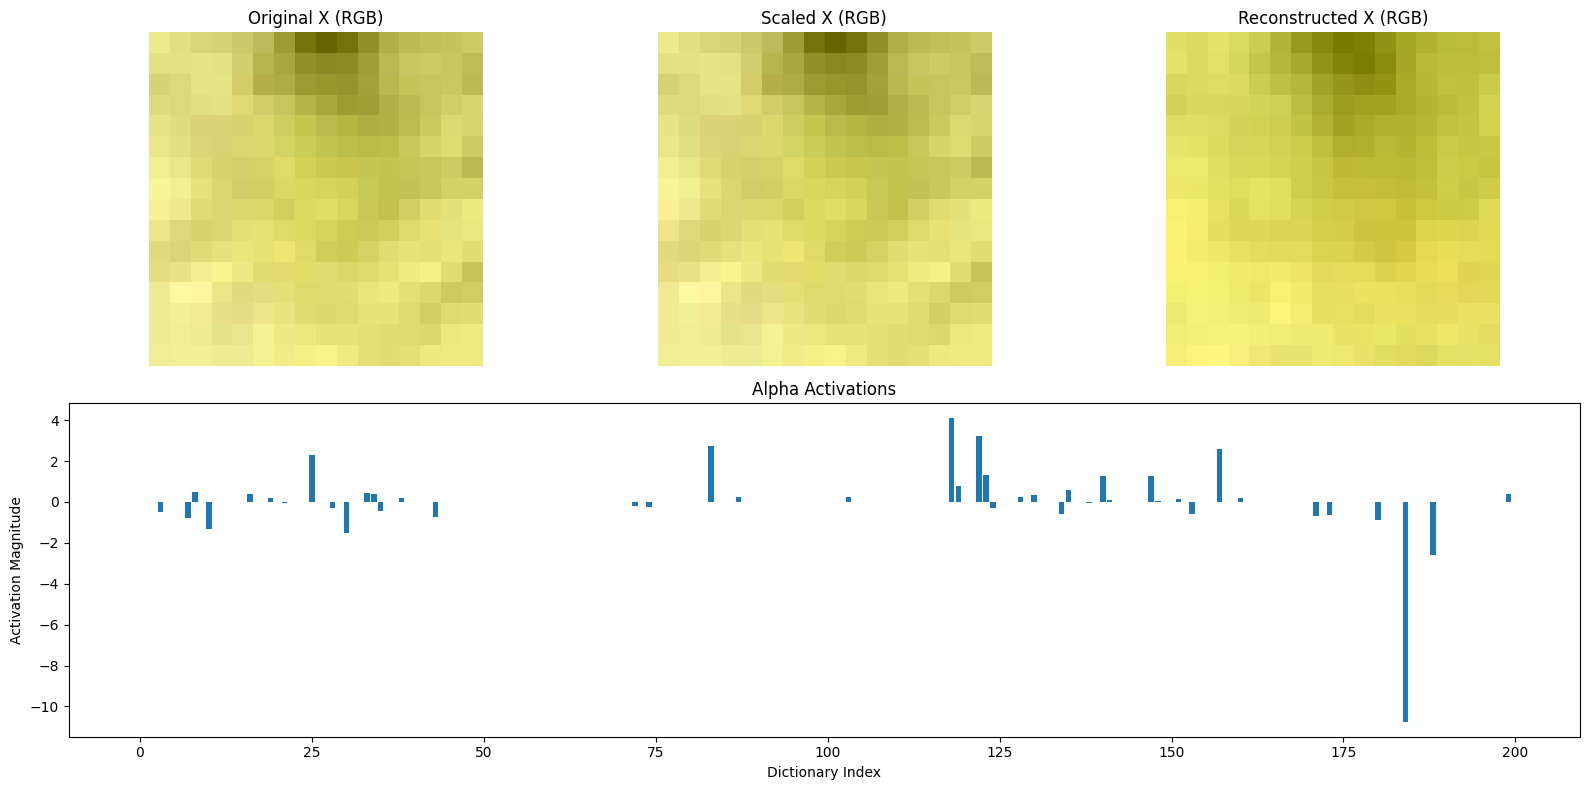

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_47865/522856424.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()


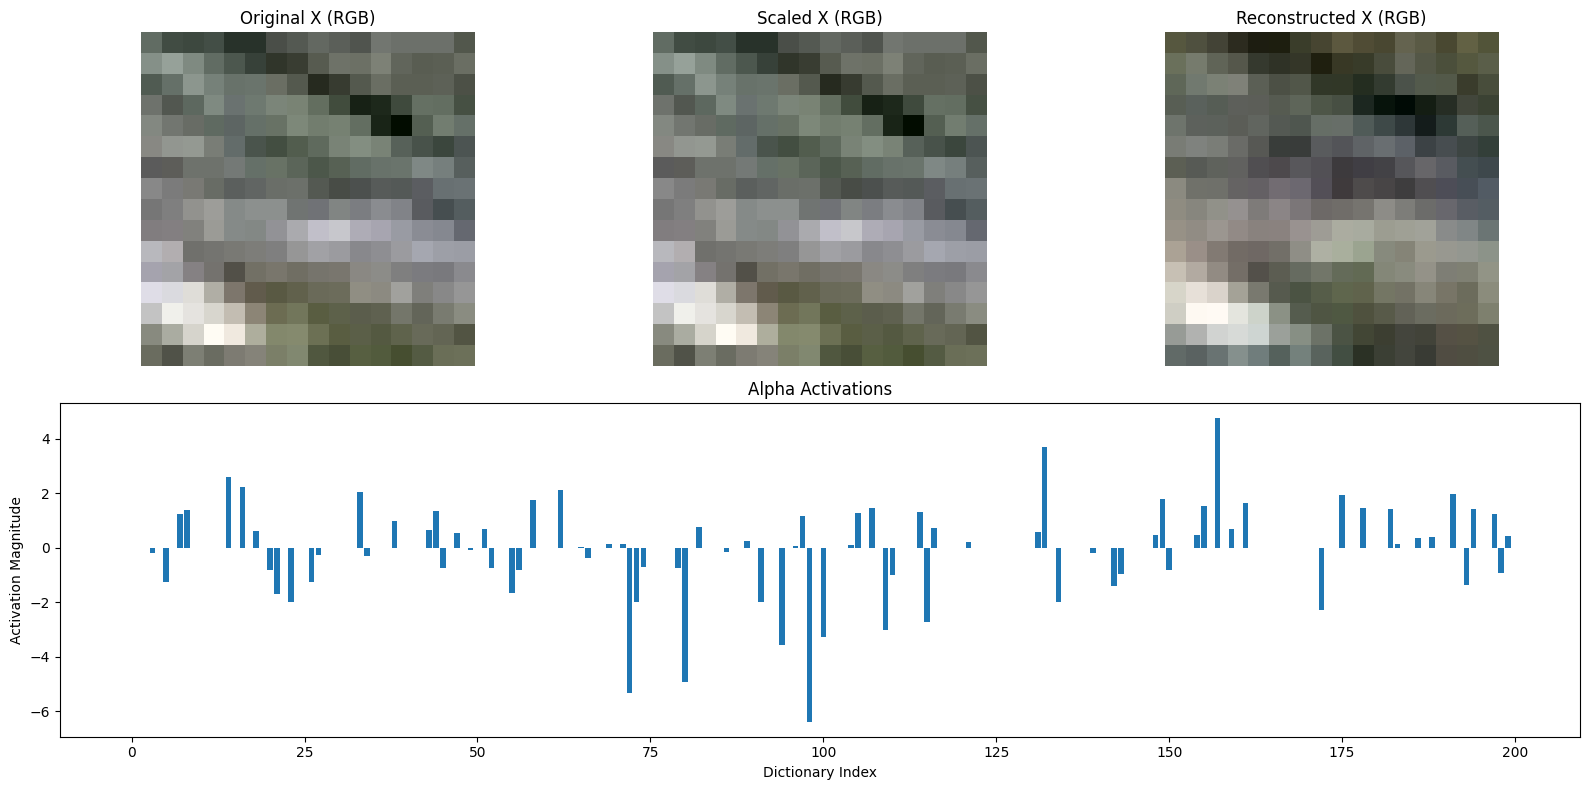

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_47865/522856424.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()


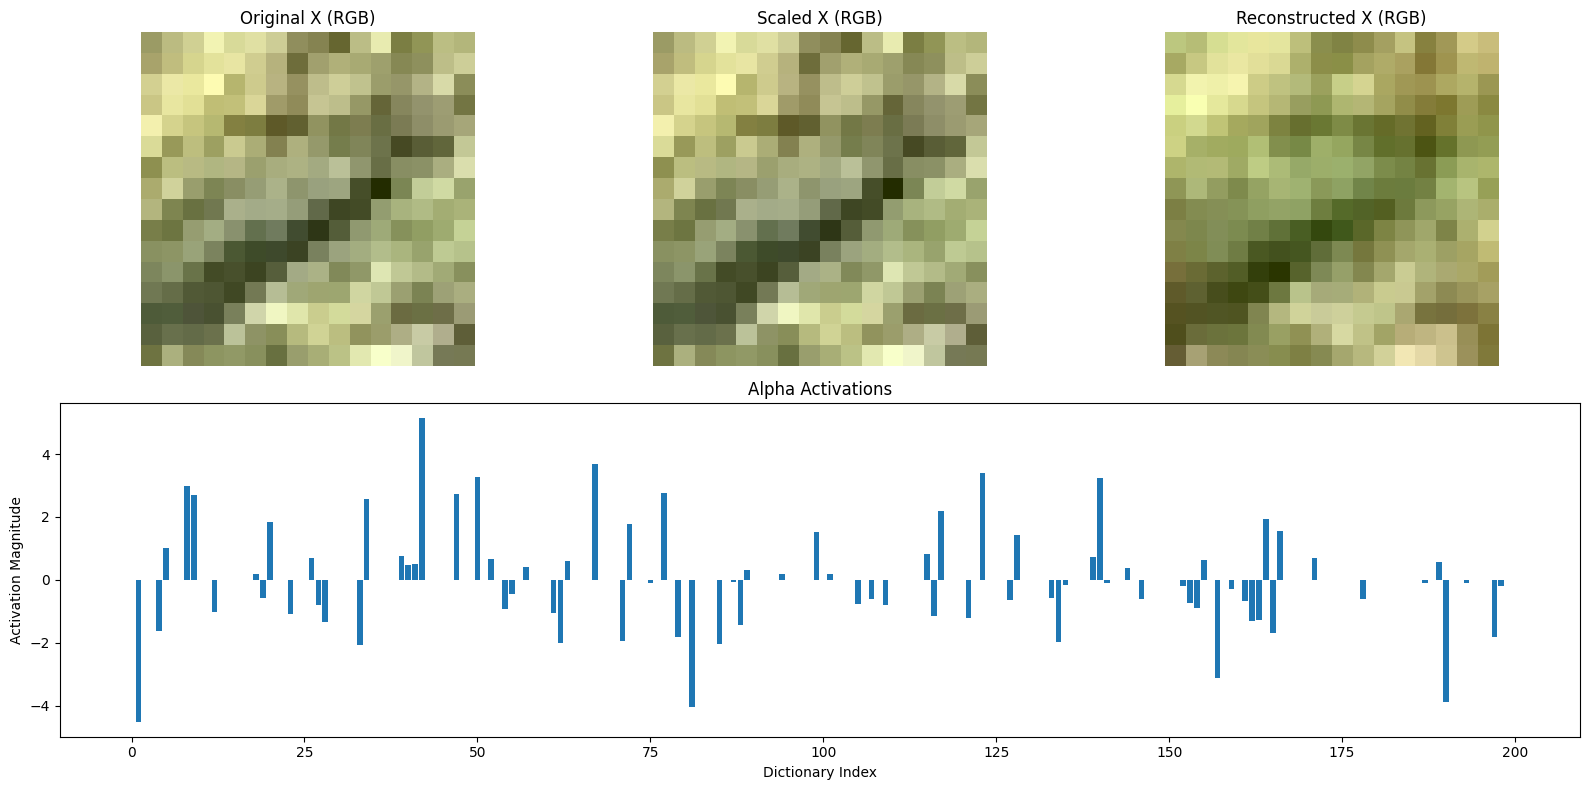

In [16]:
visualize_reconstruction(D, cycle(train_loader))

### Test Dataset

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_47865/522856424.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()


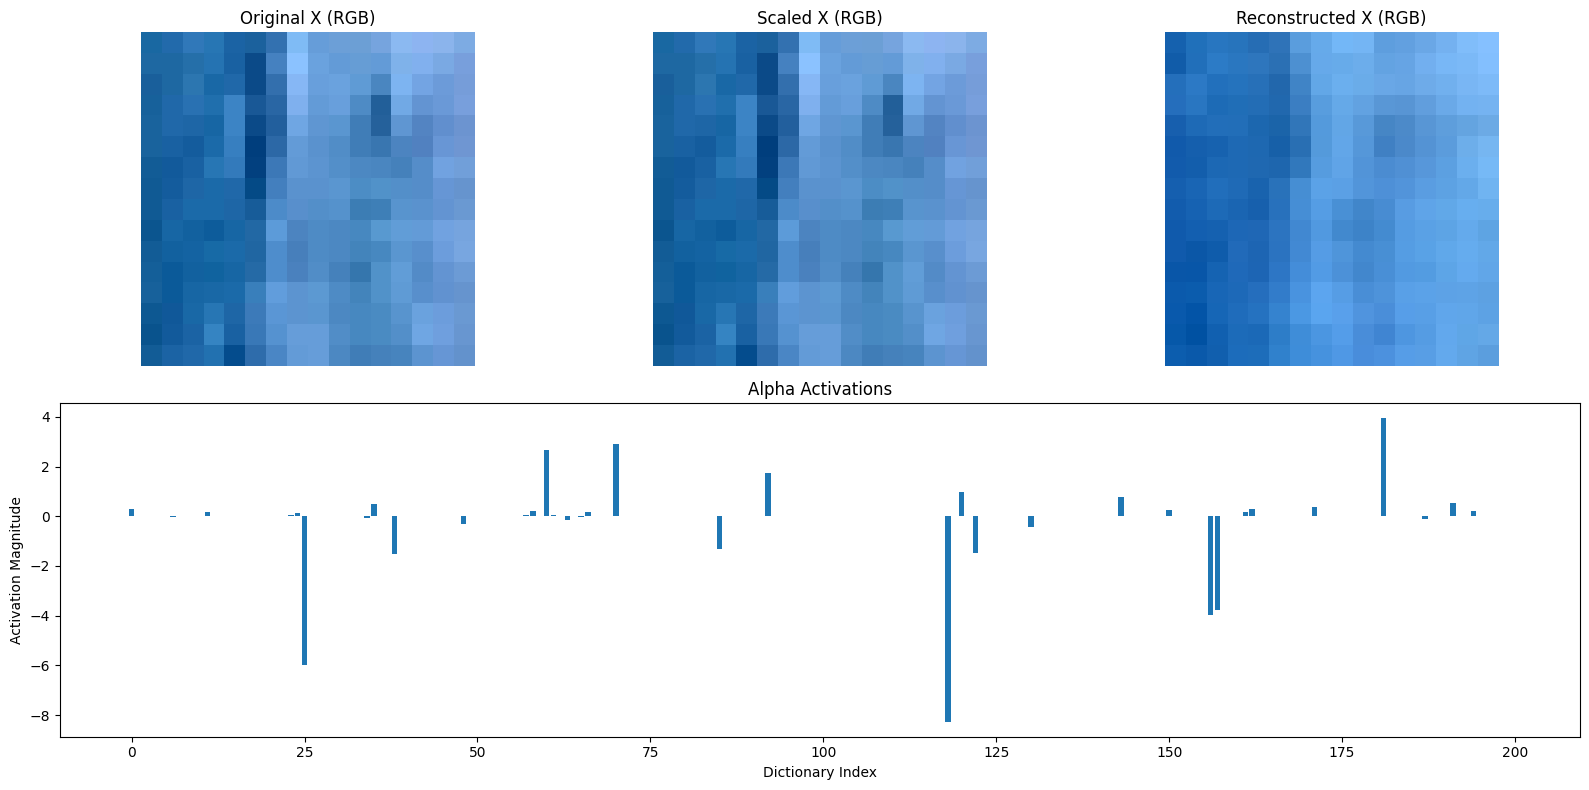

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_47865/522856424.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()


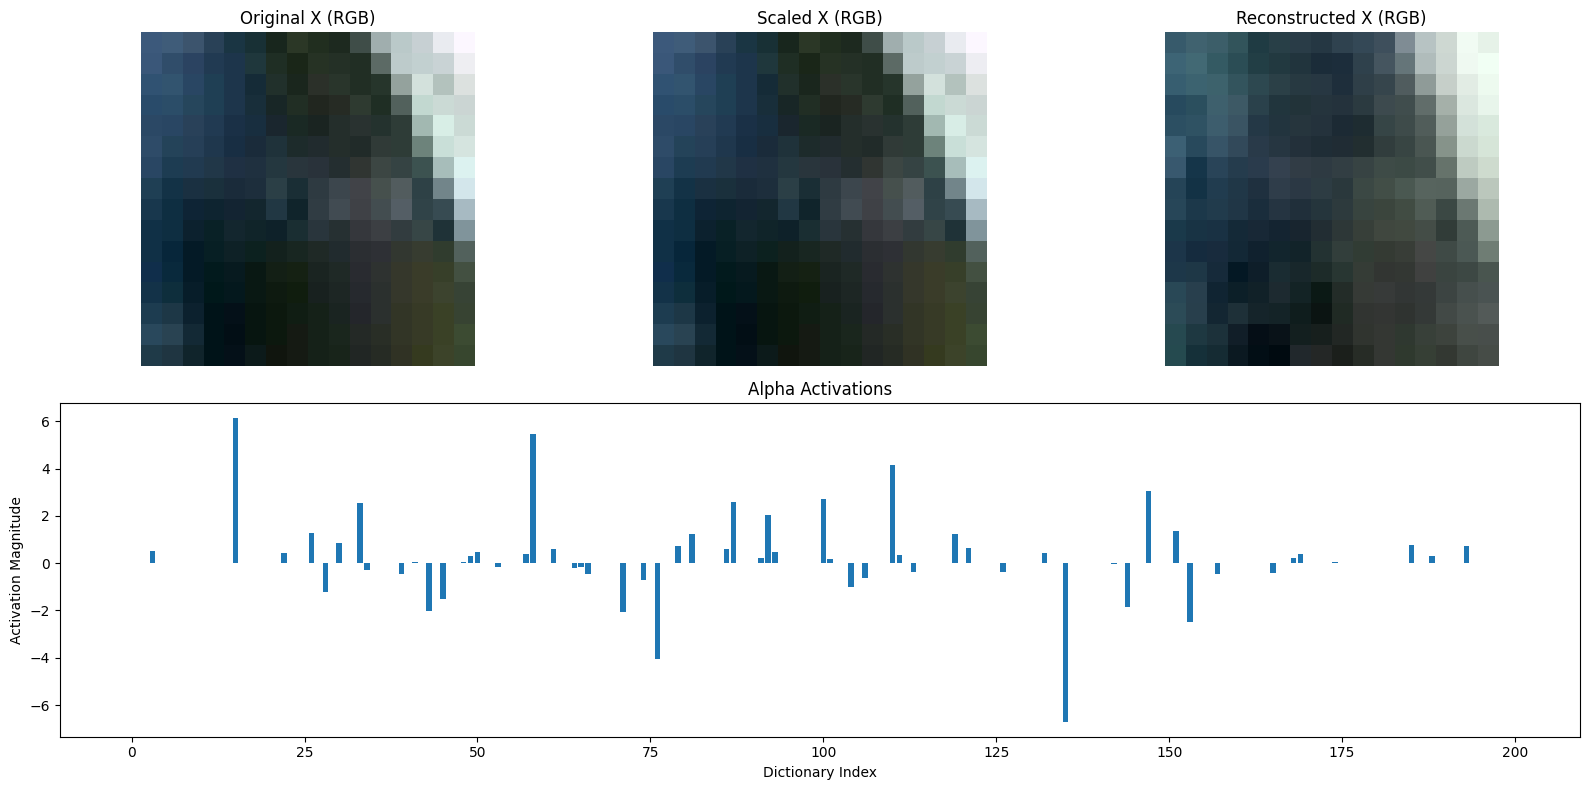

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_47865/522856424.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()


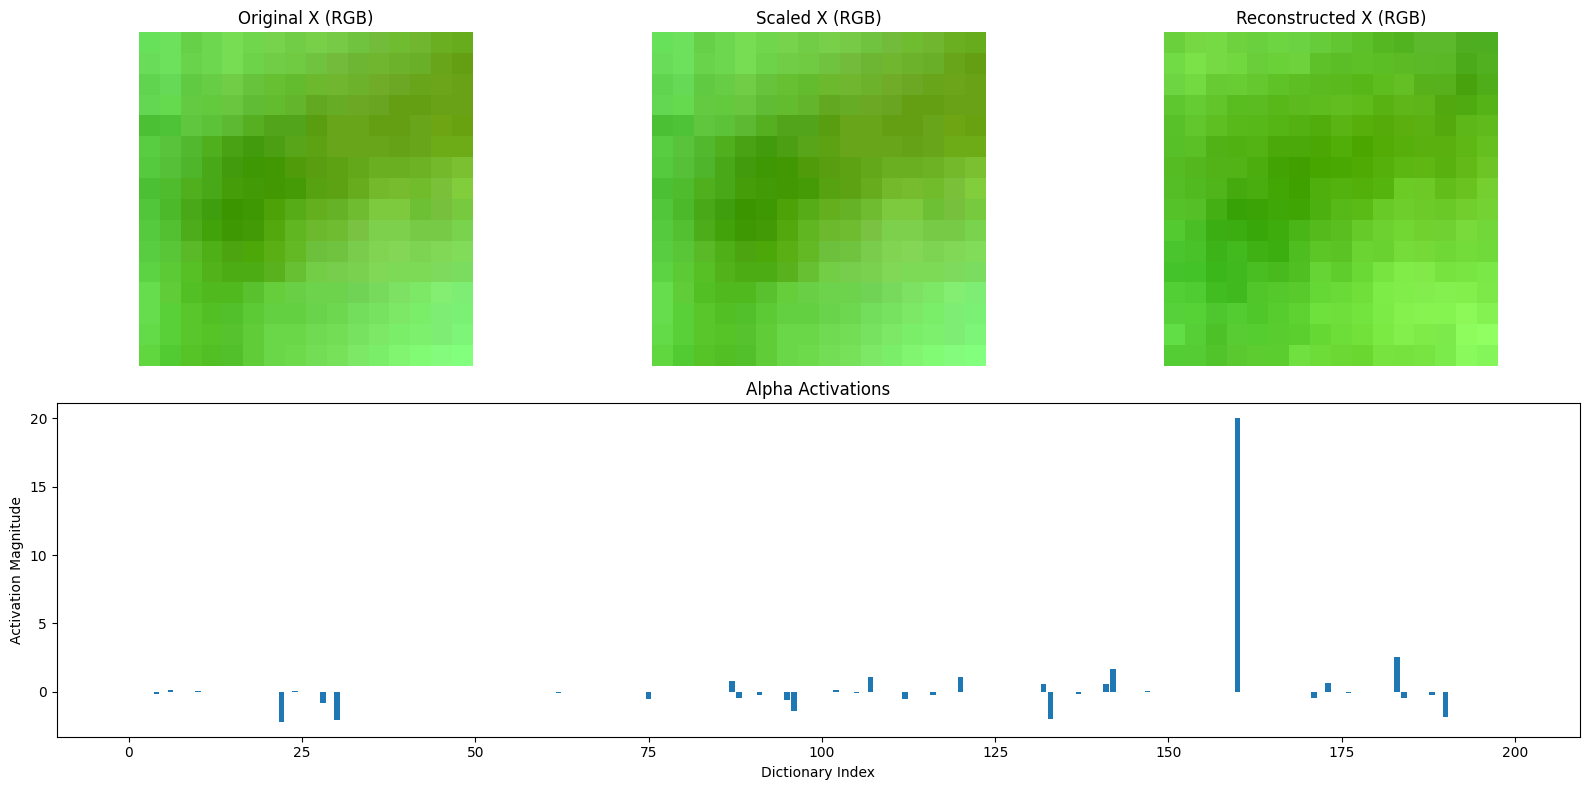

In [17]:
visualize_reconstruction(D, cycle(test_loader))

# Speed comparison

In [21]:
train_loader_1, _, _ = get_dataset("berkeley",  patch_size=(16, 16), patches_per_image=5, batch_size=1)
train_loader_16, _, _ = get_dataset("berkeley",  patch_size=(16, 16), patches_per_image=5, batch_size=16)
train_loader_512, _, _ = get_dataset("berkeley",  patch_size=(16, 16), patches_per_image=5, batch_size=512)

inf_x_loader_1 = cycle(train_loader_1)
inf_x_loader_16 = cycle(train_loader_16)
inf_x_loader_512 = cycle(train_loader_512)

m = 16*16*3
t0 = time()
_ = base_algo1(inf_x_loader_1, m=m, k=200, lbd=1.2/np.sqrt(m), tmax=int(1e3))
t1 = time()
_ = batched_algo1(inf_x_loader_16, m=m, k=200, lbd=1.2/np.sqrt(m), tmax=int(1e3)//16)
t2 = time()
_ = batched_algo1_parallel(inf_x_loader_16, m=m, k=200, lbd=1.2/np.sqrt(m), tmax=int(1e3)//16)
t3 = time()
_ = batched_algo1(inf_x_loader_512, m=m, k=200, lbd=1.2/np.sqrt(m), tmax=int(1e5)//512)
t4 = time()
_ = batched_algo1_parallel(inf_x_loader_512, m=m, k=200, lbd=1.2/np.sqrt(m), tmax=int(1e5)//512, num_workers=4)
t5 = time()

 36%|███▋      | 364/1000 [00:10<00:17, 35.87it/s]/Users/paul/.pyenv/versions/3.10.14/envs/ml4ts_venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=4.196e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/paul/.pyenv/versions/3.10.14/envs/ml4ts_venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 53 iterations, alpha=2.101e-03, previous alpha=2.098e-03, with an active set of 50 regressors.
  warnings.warn(
 43%|████▎     | 84/195 [01:31<01:53,  1.02s/it]/Users/paul/.pyenv/versions/3.10.14/envs/ml4ts_venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:755: Converg

In [22]:
print(f"""Time for training on 1 000 images:
\t-With no batching: {t1 - t0:.2f}s
\t-With batching, bs 16: {t2 - t1:.2f}s
\t-With bs 16 and parallelization: {t3 - t2:.2f}s
Time for training on 100 000 images:
\t-With bs 512: {t4 - t3:.2f}s
\t-With bs 512, parallelization: {t5 - t4:.2f}""")

Time for training on 1 000 images:
	-With no batching: 27.85s
	-With batching, bs 16: 5.49s
	-With bs 16 and parallelization: 65.56s
Time for training on 100 000 images:
	-With bs 512: 203.78s
	-With bs 512, parallelization: 275.82
